In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from tqdm import tqdm_notebook
import re

## Data Prep

In [2]:
def tokenize(text):
    # obtains tokens with a least 1 alphabet
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())

def mapping(tokens):
    word_to_id = dict()
    id_to_word = dict()

    for i, token in enumerate(set(tokens)):
        word_to_id[token] = i
        id_to_word[i] = token

    return word_to_id, id_to_word

def generate_training_data(tokens, word_to_id, window_size):
    N = len(tokens)
    X, Y = [], []

    for i in range(N):
        nbr_inds = list(range(max(0, i - window_size), i)) + \
                   list(range(i + 1, min(N, i + window_size + 1)))
        print("At index ", i, "we have: ", nbr_inds)
        for j in nbr_inds:
            X.append(word_to_id[tokens[i]])
            Y.append(word_to_id[tokens[j]])
            
    X = np.array(X)
    X = np.expand_dims(X, axis=0)
    Y = np.array(Y)
    Y = np.expand_dims(Y, axis=0)
            
    return X, Y

In [3]:
doc = "After the deduction of the costs of investing, " \
      "beating the stock market is a loser's game."
tokens = tokenize(doc)
print(tokens)

['after', 'the', 'deduction', 'of', 'the', 'costs', 'of', 'investing', 'beating', 'the', 'stock', 'market', 'is', 'a', "loser's", 'game']


In [4]:
word_to_id, id_to_word = mapping(tokens)
print(word_to_id)
print(id_to_word)

{'costs': 0, 'beating': 1, 'game': 2, 'a': 3, 'the': 4, 'after': 5, 'of': 6, 'stock': 7, 'investing': 8, 'is': 9, 'deduction': 10, "loser's": 11, 'market': 12}
{0: 'costs', 1: 'beating', 2: 'game', 3: 'a', 4: 'the', 5: 'after', 6: 'of', 7: 'stock', 8: 'investing', 9: 'is', 10: 'deduction', 11: "loser's", 12: 'market'}


In [5]:
X, Y = generate_training_data(tokens, word_to_id, 3)
print(X)
print(Y)

At index  0 we have:  [1, 2, 3]
At index  1 we have:  [0, 2, 3, 4]
At index  2 we have:  [0, 1, 3, 4, 5]
At index  3 we have:  [0, 1, 2, 4, 5, 6]
At index  4 we have:  [1, 2, 3, 5, 6, 7]
At index  5 we have:  [2, 3, 4, 6, 7, 8]
At index  6 we have:  [3, 4, 5, 7, 8, 9]
At index  7 we have:  [4, 5, 6, 8, 9, 10]
At index  8 we have:  [5, 6, 7, 9, 10, 11]
At index  9 we have:  [6, 7, 8, 10, 11, 12]
At index  10 we have:  [7, 8, 9, 11, 12, 13]
At index  11 we have:  [8, 9, 10, 12, 13, 14]
At index  12 we have:  [9, 10, 11, 13, 14, 15]
At index  13 we have:  [10, 11, 12, 14, 15]
At index  14 we have:  [11, 12, 13, 15]
At index  15 we have:  [12, 13, 14]
[[ 5  5  5  4  4  4  4 10 10 10 10 10  6  6  6  6  6  6  4  4  4  4  4  4
   0  0  0  0  0  0  6  6  6  6  6  6  8  8  8  8  8  8  1  1  1  1  1  1
   4  4  4  4  4  4  7  7  7  7  7  7 12 12 12 12 12 12  9  9  9  9  9  9
   3  3  3  3  3 11 11 11 11  2  2  2]]
[[ 4 10  6  5 10  6  4  5  4  6  4  0  5  4 10  4  0  6  4 10  6  0  6  8
  10  6 

In [6]:
vocab_size = len(id_to_word)
m = Y.shape[1]
print(m)
# turn Y into one hot encoding
Y_one_hot = np.zeros((vocab_size, m))
print(Y_one_hot)
print(Y_one_hot.shape)
print()
print(Y.flatten())
Y_one_hot[Y.flatten(), np.arange(m)] = 1
print(Y_one_hot)

84
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(13, 84)

[ 4 10  6  5 10  6  4  5  4  6  4  0  5  4 10  4  0  6  4 10  6  0  6  8
 10  6  4  6  8  1  6  4  0  8  1  4  4  0  6  1  4  7  0  6  8  4  7 12
  6  8  1  7 12  9  8  1  4 12  9  3  1  4  7  9  3 11  4  7 12  3 11  2
  7 12  9 11  2 12  9  3  2  9  3 11]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]


## Initialization

In [7]:
def initialize_wrd_emb(vocab_size, emb_size):
    """
    vocab_size: int. vocabulary size of your corpus or training data
    emb_size: int. word embedding size. How many dimensions to represent each vocabulary
    """
    WRD_EMB = np.random.randn(vocab_size, emb_size) * 0.01
    
    assert(WRD_EMB.shape == (vocab_size, emb_size))
    return WRD_EMB

def initialize_dense(input_size, output_size):
    """
    input_size: int. size of the input to the dense layer
    output_szie: int. size of the output out of the dense layer
    """
    W = np.random.randn(output_size, input_size) * 0.01
    
    assert(W.shape == (output_size, input_size))
    return W

def initialize_parameters(vocab_size, emb_size):
    WRD_EMB = initialize_wrd_emb(vocab_size, emb_size)
    W = initialize_dense(emb_size, vocab_size)
    
    parameters = {}
    parameters['WRD_EMB'] = WRD_EMB
    parameters['W'] = W
    
    return parameters

## Forward Propagation

In [8]:
def ind_to_word_vecs(inds, parameters):
    """
    inds: numpy array. shape: (1, m)
    parameters: dict. weights to be trained
    """
    m = inds.shape[1]
    WRD_EMB = parameters['WRD_EMB']
    word_vec = WRD_EMB[inds.flatten(), :].T
    
    assert(word_vec.shape == (WRD_EMB.shape[1], m))
    
    return word_vec

def linear_dense(word_vec, parameters):
    """
    word_vec: numpy array. shape: (emb_size, m)
    parameters: dict. weights to be trained
    """
    m = word_vec.shape[1]
    W = parameters['W']
    Z = np.dot(W, word_vec)
    
    assert(Z.shape == (W.shape[0], m))
    
    return W, Z

def softmax(Z):
    """
    Z: output out of the dense layer. shape: (vocab_size, m)
    """
    softmax_out = np.divide(np.exp(Z), np.sum(np.exp(Z), axis=0, keepdims=True) + 0.001)
    
    assert(softmax_out.shape == Z.shape)

    return softmax_out

def forward_propagation(inds, parameters):
    word_vec = ind_to_word_vecs(inds, parameters)
    W, Z = linear_dense(word_vec, parameters)
    softmax_out = softmax(Z)
    
    caches = {}
    caches['inds'] = inds
    caches['word_vec'] = word_vec
    caches['W'] = W
    caches['Z'] = Z
    
    return softmax_out, caches

## Cost Function

In [9]:
def cross_entropy(softmax_out, Y):
    """
    softmax_out: output out of softmax. shape: (vocab_size, m)
    """
    m = softmax_out.shape[1]
    cost = -(1 / m) * np.sum(np.sum(Y * np.log(softmax_out + 0.001), axis=0, keepdims=True), axis=1)
    return cost

## Backward Propagation

In [10]:
def softmax_backward(Y, softmax_out):
    """
    Y: labels of training data. shape: (vocab_size, m)
    softmax_out: output out of softmax. shape: (vocab_size, m)
    """
    dL_dZ = softmax_out - Y
    
    assert(dL_dZ.shape == softmax_out.shape)
    return dL_dZ

def dense_backward(dL_dZ, caches):
    """
    dL_dZ: shape: (vocab_size, m)
    caches: dict. results from each steps of forward propagation
    """
    W = caches['W']
    word_vec = caches['word_vec']
    m = word_vec.shape[1]
    
    dL_dW = (1 / m) * np.dot(dL_dZ, word_vec.T)
    dL_dword_vec = np.dot(W.T, dL_dZ)

    assert(W.shape == dL_dW.shape)
    assert(word_vec.shape == dL_dword_vec.shape)
    
    return dL_dW, dL_dword_vec

def backward_propagation(Y, softmax_out, caches):
    dL_dZ = softmax_backward(Y, softmax_out)
    dL_dW, dL_dword_vec = dense_backward(dL_dZ, caches)
    
    gradients = dict()
    gradients['dL_dZ'] = dL_dZ
    gradients['dL_dW'] = dL_dW
    gradients['dL_dword_vec'] = dL_dword_vec
    
    return gradients

def update_parameters(parameters, caches, gradients, learning_rate):
    vocab_size, emb_size = parameters['WRD_EMB'].shape
    inds = caches['inds']
    dL_dword_vec = gradients['dL_dword_vec']
    m = inds.shape[-1]
    
    parameters['WRD_EMB'][inds.flatten(), :] -= dL_dword_vec.T * learning_rate

    parameters['W'] -= learning_rate * gradients['dL_dW']
    

In [11]:
from datetime import datetime

import matplotlib.pyplot as plt


def skipgram_model_training(X, Y, vocab_size, emb_size, learning_rate, epochs, batch_size=256, parameters=None, print_cost=False, plot_cost=True):
    costs = []
    m = X.shape[1]
    
    if parameters is None:
        parameters = initialize_parameters(vocab_size, emb_size)
    
    begin_time = datetime.now()
    for epoch in range(epochs):
        epoch_cost = 0
        batch_inds = list(range(0, m, batch_size))
        np.random.shuffle(batch_inds)
        for i in batch_inds:
            X_batch = X[:, i:i+batch_size]
            Y_batch = Y[:, i:i+batch_size]

            softmax_out, caches = forward_propagation(X_batch, parameters)
            #print("softmax size is: ", softmax_out.shape)
            gradients = backward_propagation(Y_batch, softmax_out, caches)
            update_parameters(parameters, caches, gradients, learning_rate)
            cost = cross_entropy(softmax_out, Y_batch)
            epoch_cost += np.squeeze(cost) # turn ndarray into floating number
            
        costs.append(epoch_cost)
        if print_cost and epoch % 10 == 0:
            print("Cost after epoch {}: {}".format(epoch, epoch_cost))
        if epoch % 100 == 0:
            learning_rate *= 0.98
    end_time = datetime.now()
    print('training time: {}'.format(end_time - begin_time))
            
    if plot_cost:
        plt.plot(np.arange(epochs), costs)
        plt.xlabel('# of epochs')
        plt.ylabel('cost')
    return parameters

Cost after epoch 0: 2.552108809331128
Cost after epoch 10: 2.5518043033291877
Cost after epoch 20: 2.5514883314170094
Cost after epoch 30: 2.551144709162928
Cost after epoch 40: 2.5507571123836366
Cost after epoch 50: 2.550307986453164
Cost after epoch 60: 2.549778045210645
Cost after epoch 70: 2.5491457292667064
Cost after epoch 80: 2.54838661324859
Cost after epoch 90: 2.5474727537866486
Cost after epoch 100: 2.546371973799601
Cost after epoch 110: 2.545073063542792
Cost after epoch 120: 2.5435207775474984
Cost after epoch 130: 2.5416660959411246
Cost after epoch 140: 2.539455493714363
Cost after epoch 150: 2.5368278790049206
Cost after epoch 160: 2.5337141377780945
Cost after epoch 170: 2.5300370437191284
Cost after epoch 180: 2.525711764961187
Cost after epoch 190: 2.520647281454295
Cost after epoch 200: 2.5147491148013263
Cost after epoch 210: 2.508055026109384
Cost after epoch 220: 2.5004022573582705
Cost after epoch 230: 2.4917133166764502
Cost after epoch 240: 2.481950220605665

Cost after epoch 2450: 2.0419239606006614
Cost after epoch 2460: 2.0417435147743266
Cost after epoch 2470: 2.0415621191202975
Cost after epoch 2480: 2.0413800890720286
Cost after epoch 2490: 2.041197735794402
Cost after epoch 2500: 2.041015365305019
Cost after epoch 2510: 2.0408366817242705
Cost after epoch 2520: 2.0406589139875764
Cost after epoch 2530: 2.040481945772729
Cost after epoch 2540: 2.0403060400404236
Cost after epoch 2550: 2.0401314526005048
Cost after epoch 2560: 2.03995843023839
Cost after epoch 2570: 2.039787209952189
Cost after epoch 2580: 2.03961801843256
Cost after epoch 2590: 2.039451071612932
Cost after epoch 2600: 2.039286574250334
Cost after epoch 2610: 2.0391277334411373
Cost after epoch 2620: 2.03897193080323
Cost after epoch 2630: 2.0388189793448563
Cost after epoch 2640: 2.038669028281103
Cost after epoch 2650: 2.0385222157870273
Cost after epoch 2660: 2.0383786675395776
Cost after epoch 2670: 2.038238496294052
Cost after epoch 2680: 2.0381018016630357
Cost a

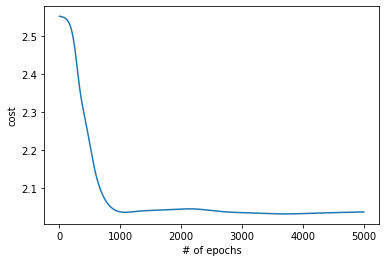

In [12]:
paras = skipgram_model_training(X, Y_one_hot, vocab_size, 50, 0.05, 5000, batch_size=128, parameters=None, print_cost=True)

In [13]:
print(paras.keys())

dict_keys(['WRD_EMB', 'W'])


In [14]:
print(paras["WRD_EMB"].shape)
print(paras["WRD_EMB"])

(13, 50)
[[-1.94240532e+00  1.25388014e+00  8.52578571e-01 -2.98138017e+00
  -2.58780717e+00 -9.71020430e-04 -1.73553609e+00  1.12999026e-01
  -2.35643225e+00  1.95908586e+00  2.76110961e+00 -5.44402389e-01
   1.71649252e-02 -1.34423255e+00 -1.94388373e+00 -3.41736748e+00
   1.36062969e+00  1.84118486e+00 -9.37857311e-01 -3.14939284e+00
   3.70016337e+00  2.75222266e-01  4.01376679e+00  2.31607604e+00
  -3.78692573e+00 -6.96532942e-01  1.23531761e+00 -1.96679841e+00
  -1.59796159e+00  3.76965112e-01 -4.35389891e-01 -2.64731268e+00
  -2.48749107e+00  2.62133150e+00 -2.77336286e+00 -5.56669983e-01
   3.81531447e-01 -3.20986215e+00  7.25909928e-02 -1.77044623e+00
  -1.99152807e+00  1.61951290e+00  1.42550694e+00  7.80641078e-01
   2.23890659e+00  1.62618909e+00 -1.07357472e+00  3.71057956e-01
  -2.29688274e+00 -3.24455311e+00]
 [ 9.31320328e-01 -2.91464645e+00 -2.47248438e-01  1.70027301e+00
   1.08019738e-01  3.72189306e-02 -4.43406387e-01  4.65893139e-01
   1.18804537e+00  1.68441324e+0

In [15]:
print(paras["W"].shape)
print(paras["W"])

(13, 50)
[[ 1.07483755e-01 -4.61282054e-02 -1.09460902e-02 -1.84773246e-01
   1.78259483e-01  4.73607050e-02  4.81776362e-02 -1.44439323e-01
   2.31756607e-01  2.38543082e-01 -2.54454081e-02 -5.00660086e-02
   1.80203353e-01 -4.43203881e-01  1.31904331e-01  9.61572073e-02
  -3.96034030e-02 -2.76891598e-01  5.14007097e-02 -2.46473798e-01
  -1.35579735e-01 -2.66893268e-01  2.34378665e-01 -2.99851764e-01
   5.54027386e-03  1.67338666e-01  1.12369116e-01  1.07232859e-01
  -3.04131354e-02 -6.08423464e-02 -6.41920298e-02 -4.64976649e-02
  -1.44549470e-01 -4.26620644e-02 -1.17600019e-01  2.09101316e-02
  -3.15207180e-01  2.10171435e-02  1.04380235e-01  1.14968697e-01
   2.99682830e-01  8.29542618e-02 -9.88975523e-02  3.88785950e-01
  -4.21420293e-01  3.42267949e-02  2.08611693e-01  3.54049504e-01
  -2.15470079e-02 -1.10387249e-01]
 [-5.36902252e-02 -1.15433197e-02 -7.02155264e-02 -9.52782341e-02
  -5.37842624e-03  4.78770061e-02 -2.14661090e-03 -5.60695334e-02
   1.97369266e-01  2.29959008e-0

## Evaluate

In [16]:
X_test = np.arange(vocab_size)
X_test = np.expand_dims(X_test, axis=0)
print(X_test)
print()
softmax_test, _ = forward_propagation(X_test, paras)
top_sorted_inds = np.argsort(softmax_test, axis=0)[-4:,:]
print(top_sorted_inds)

[[ 0  1  2  3  4  5  6  7  8  9 10 11 12]]

[[ 4  8  1 11  7  0  5  1  6 11  1 11  1]
 [10  0  3  7  1 10  0  9  1  7  4  7  3]
 [ 6  7 11 12  6  4  6  3  7 12  5 12 11]
 [ 1 12  9  2  9  6  4  8  4  2  0  2  9]]


In [17]:
top_sorted_inds[::-1]

array([[ 1, 12,  9,  2,  9,  6,  4,  8,  4,  2,  0,  2,  9],
       [ 6,  7, 11, 12,  6,  4,  6,  3,  7, 12,  5, 12, 11],
       [10,  0,  3,  7,  1, 10,  0,  9,  1,  7,  4,  7,  3],
       [ 4,  8,  1, 11,  7,  0,  5,  1,  6, 11,  1, 11,  1]])

In [18]:
top_sorted_inds[::-1, 0]

array([ 1,  6, 10,  4])

In [19]:
for input_ind in range(vocab_size):
    input_word = id_to_word[input_ind]
    output_words = [id_to_word[output_ind] for output_ind in top_sorted_inds[::-1, input_ind]]
    print("{}'s top {} neighbor words: {}".format(input_word, len(output_words), output_words))

costs's top 4 neighbor words: ['beating', 'of', 'deduction', 'the']
beating's top 4 neighbor words: ['market', 'stock', 'costs', 'investing']
game's top 4 neighbor words: ['is', "loser's", 'a', 'beating']
a's top 4 neighbor words: ['game', 'market', 'stock', "loser's"]
the's top 4 neighbor words: ['is', 'of', 'beating', 'stock']
after's top 4 neighbor words: ['of', 'the', 'deduction', 'costs']
of's top 4 neighbor words: ['the', 'of', 'costs', 'after']
stock's top 4 neighbor words: ['investing', 'a', 'is', 'beating']
investing's top 4 neighbor words: ['the', 'stock', 'beating', 'of']
is's top 4 neighbor words: ['game', 'market', 'stock', "loser's"]
deduction's top 4 neighbor words: ['costs', 'after', 'the', 'beating']
loser's's top 4 neighbor words: ['game', 'market', 'stock', "loser's"]
market's top 4 neighbor words: ['is', "loser's", 'a', 'beating']
